# This noteboook is aimed at modelling returns of Bitcoin using traditional econometrics approach

## Importing libraries

In [1]:
# basic data-handling libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# libraries used in dataimports and modifications
from tvDatafeed import TvDatafeed, Interval
import pandas_ta as ta
import requests
import json
import datetime

In [3]:
# library for statistical analysis
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [4]:
# utilities
import sys
import nltk
sys.path.append('modules')
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kotakikuchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing data

In [5]:
bitcoin = utils.get_data('BTCUSDT', exchange = 'BINANCE',start_date = "2020-01-01")

you are using nologin method, data you access may be limited


In [6]:
#twitter = utils.processed_twitter_data()
# twitter_daily = twitter[['sentiment','created_at']].resample('D', on='created_at').mean()
# twitter_daily.index = twitter_daily.index.tz_localize(None)


In [7]:
twitter_daily = pd.read_pickle('../data/cleaned/by_date_verified_weighted_sentiment_2020-2021.pkl')

In [8]:
merged_df = bitcoin.merge(twitter_daily, how = 'outer', left_on = 'datetime', right_on = 'created_at')

In [9]:
merged_df.head()

,datetime,symbol,open,high,low,close,volume,created_at,weighted_sentiment
0,2020-01-01,BINANCE:BTCUSDT,7200.77,7212.50,6924.74,6965.71,31951.483932,2020-01-01,0.126772
1,2020-01-02,BINANCE:BTCUSDT,6965.49,7405.00,6871.04,7344.96,68428.500451,2020-01-02,0.073418
2,2020-01-03,BINANCE:BTCUSDT,7345.00,7404.00,7272.21,7354.11,29987.974977,2020-01-03,0.145800
3,2020-01-04,BINANCE:BTCUSDT,7354.19,7495.00,7318.00,7358.75,38331.085604,2020-01-04,0.087736
4,2020-01-05,BINANCE:BTCUSDT,7357.64,7795.34,7346.76,7758.00,54635.695316,2020-01-05,0.057072


### Linear Regression

Features - technical indicators.
Reference: https://www.alpharithms.com/predicting-stock-prices-with-linear-regression-214618/


In [10]:
'''
function to calculate technical indicators'''
def technical_indicator(df, column, technical_indicator, length):
    
    if technical_indicator == 'EMA':
        df.ta.ema(close = column, length = length, append = True, lookahead=False)
        
    return df
       
    

In [11]:
merged_df = technical_indicator(merged_df, 'close', 'EMA', length = 2)
merged_df = utils.lag_columns(merged_df, ['EMA_2'], +1)
merged_df = utils.lag_columns(merged_df, ['weighted_sentiment'], +1)

merged_df = utils.calculate_return(merged_df, ['close','EMA_2_1_days_lagged', 'weighted_sentiment_1_days_lagged'], 1)

merged_df = utils.lag_columns(merged_df, ['close_return'], -1)


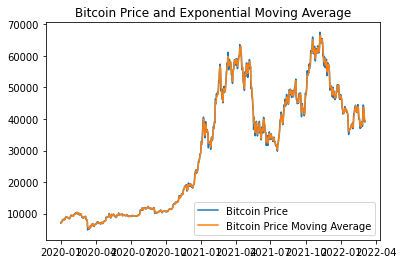

In [12]:
fig, ax = plt.subplots()

ax.plot(merged_df['datetime'],merged_df['close'], label = 'Bitcoin Price')
ax.plot(merged_df['datetime'],merged_df['EMA_2'], label = 'Bitcoin Price Moving Average')

plt.title("Bitcoin Price and Exponential Moving Average")
plt.legend()

# We need to lag the features to avoid leakage (lookahead bias). That is, you cannot use tomorrow's data to predict the price for tomorrow. We need to use what we know today to predict the price tomorrow.

should this be tomorrow's return? because we want to trade beased on what we know today

In [13]:
merged_df.head()

,datetime,symbol,open,high,low,close,volume,created_at,weighted_sentiment,EMA_2,EMA_2_1_days_lagged,weighted_sentiment_1_days_lagged,close_return,EMA_2_1_days_lagged_return,weighted_sentiment_1_days_lagged_return,close_return_negative_1_days_lagged
0,2020-01-01,BINANCE:BTCUSDT,7200.77,7212.50,6924.74,6965.71,31951.483932,2020-01-01,0.126772,NaN,NaN,NaN,NaN,NaN,NaN,0.054445
1,2020-01-02,BINANCE:BTCUSDT,6965.49,7405.00,6871.04,7344.96,68428.500451,2020-01-02,0.073418,7155.335000,NaN,0.126772,0.054445,NaN,NaN,0.001246
2,2020-01-03,BINANCE:BTCUSDT,7345.00,7404.00,7272.21,7354.11,29987.974977,2020-01-03,0.145800,7287.851667,7155.335000,0.073418,0.001246,NaN,-0.420864,0.000631
3,2020-01-04,BINANCE:BTCUSDT,7354.19,7495.00,7318.00,7358.75,38331.085604,2020-01-04,0.087736,7335.117222,7287.851667,0.145800,0.000631,0.018520,0.985891,0.054255
4,2020-01-05,BINANCE:BTCUSDT,7357.64,7795.34,7346.76,7758.00,54635.695316,2020-01-05,0.057072,7617.039074,7335.117222,0.087736,0.054255,0.006486,-0.398246,0.049920


<AxesSubplot:ylabel='Frequency'>

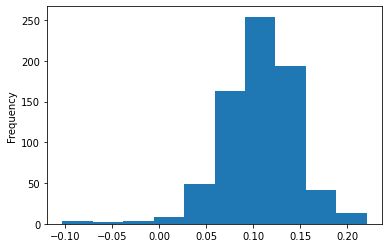

In [14]:
merged_df['weighted_sentiment_1_days_lagged'].plot(kind = 'hist')

Correlation between change in sentiment and return on bitcoin

In [15]:
formula_2 = 'close_return_negative_1_days_lagged ~ weighted_sentiment_1_days_lagged_return '
res_2 = ols(formula_2, data= merged_df).fit()

In [16]:
print(res_2.summary())

                                     OLS Regression Results                                    
Dep. Variable:     close_return_negative_1_days_lagged   R-squared:                       0.000
Model:                                             OLS   Adj. R-squared:                 -0.001
Method:                                  Least Squares   F-statistic:                    0.3893
Date:                                 Sun, 06 Mar 2022   Prob (F-statistic):              0.533
Time:                                         17:33:25   Log-Likelihood:                 1412.2
No. Observations:                                  792   AIC:                            -2820.
Df Residuals:                                      790   BIC:                            -2811.
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
                                        

In [17]:
print(res_2.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                               & close\_return\_negative\_1\_days\_lagged & \textbf{  R-squared:         } &     0.000   \\
\textbf{Model:}                                       &                   OLS                    & \textbf{  Adj. R-squared:    } &    -0.001   \\
\textbf{Method:}                                      &              Least Squares               & \textbf{  F-statistic:       } &    0.3893   \\
\textbf{Date:}                                        &             Sun, 06 Mar 2022             & \textbf{  Prob (F-statistic):} &    0.533    \\
\textbf{Time:}                                        &                 17:33:34                 & \textbf{  Log-Likelihood:    } &    1412.2   \\
\textbf{No. Observations:}                            &                     792                  & \textbf{  AIC:               } &    -2820.   \\
\textbf{Df Residuals:}                                &                 

Correlation between sentiment and bitcoin return

In [18]:
formula_3 = 'close_return_negative_1_days_lagged ~ weighted_sentiment_1_days_lagged'
res_3 = ols(formula_3, data= merged_df).fit()

In [19]:
print(res_3.summary())

                                     OLS Regression Results                                    
Dep. Variable:     close_return_negative_1_days_lagged   R-squared:                       0.000
Model:                                             OLS   Adj. R-squared:                 -0.001
Method:                                  Least Squares   F-statistic:                    0.1001
Date:                                 Sun, 06 Mar 2022   Prob (F-statistic):              0.752
Time:                                         17:33:39   Log-Likelihood:                 1299.1
No. Observations:                                  731   AIC:                            -2594.
Df Residuals:                                      729   BIC:                            -2585.
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
                                       c

In [20]:
print(res_3.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                       & close\_return\_negative\_1\_days\_lagged & \textbf{  R-squared:         } &     0.000   \\
\textbf{Model:}                               &                   OLS                    & \textbf{  Adj. R-squared:    } &    -0.001   \\
\textbf{Method:}                              &              Least Squares               & \textbf{  F-statistic:       } &    0.1001   \\
\textbf{Date:}                                &             Sun, 06 Mar 2022             & \textbf{  Prob (F-statistic):} &    0.752    \\
\textbf{Time:}                                &                 17:33:41                 & \textbf{  Log-Likelihood:    } &    1299.1   \\
\textbf{No. Observations:}                    &                     731                  & \textbf{  AIC:               } &    -2594.   \\
\textbf{Df Residuals:}                        &                     729                  & \textbf{  BIC:               